# Application of Explainable Machine Learning on Prediction

## Dataset: ba

*   4 Features
*   Predict class: [1, 2]



### Loading Packages

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ef632635705ae50c732a5e5c747a14856020a245f2a49ea9ac421ab9d470fbc5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scipy.stats import uniform, randint
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lime
import lime.lime_tabular
import shap

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [ ]:
# Load the data
ba = pd.read_csv('ba.csv')
ba = ba.drop(columns = 'Unnamed: 0')
ba.head()

,V1,V2,V3,V4,class
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


In [ ]:
# Check missing data
ba.isnull().sum()
# Again make sure there's no missing value
assert ba.isna().sum().sum() == 0

There's no missing value.

### Data Visualization

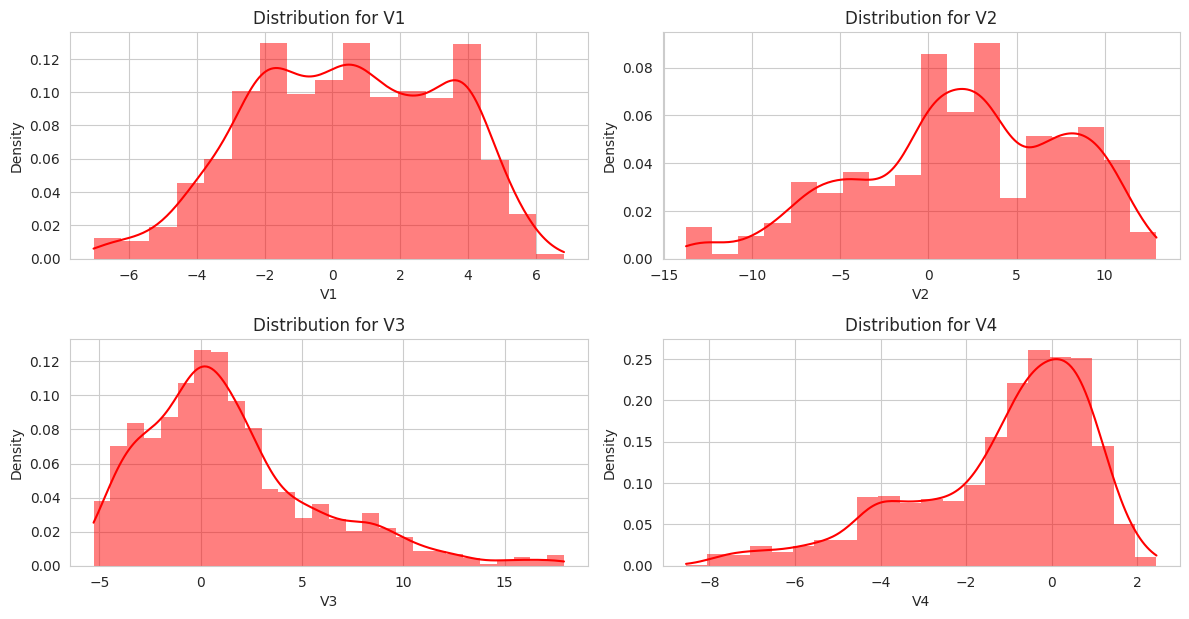

In [ ]:
# Select features
features = ['V1', 'V2', 'V3', 'V4']

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plot layout
n_rows = 4
n_cols = 2
plt.figure(figsize=(12, 12))

# Loop through the features and create a histogram for each
for i, feature in enumerate(features):
  plt.subplot(n_rows, n_cols, i + 1)
  sns.histplot(ba[feature], kde=True, color='red', stat="density", linewidth=0)
  plt.title(f'Distribution for {feature}')
  plt.xlabel(feature)
  plt.ylabel('Density')

# Display the plots
plt.tight_layout()
plt.show()

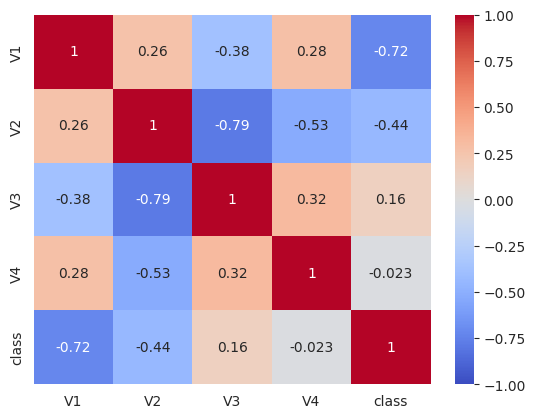

In [ ]:
# Correlation Map
corr = ba.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

Overall, the heatmap indicates that the physical size and weight measurements of abalones are highly interrelated, while the 'Sex' of the abalone does not have a strong linear relationship with its physical measurements.

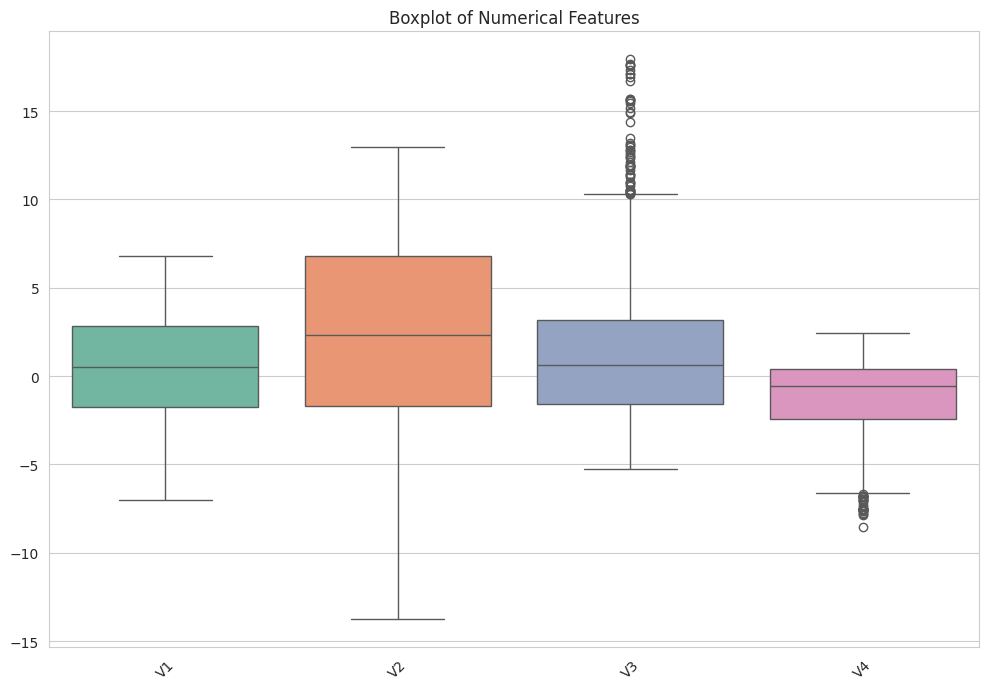

In [ ]:
# Plotting boxplot for all numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=ba[['V1', 'V2', 'V3', 'V4']], palette="Set2")
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

The scales of each features differ, and thus standardization is needed.

### Data Preprocessing

In [ ]:
# Identify features and labels
X = ba.drop('class', axis=1)
y = ba['class']

# Standardize the numerical variables
scaler = StandardScaler()

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.fit_transform(X_test_unscaled)

### Model Building & Evaluation

#### Logistic Regression

In [ ]:
# Logistic Regression
label_encoder = LabelEncoder()
label_encoder.fit(y)

lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

# Evaluation
class_names = [str(cls) for cls in label_encoder.classes_]
lr_report = classification_report(y_test, y_pred_lr, target_names = class_names)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
log_loss_lr = log_loss(y_test, y_pred_proba_lr)

# Results
print('Logistics Regression Evaluation\n')
print(lr_report)
print(f'Accuracy: {accuracy_lr}\nLog Loss: {log_loss_lr}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       148
           2       0.97      0.98      0.98       127

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275

Accuracy: 0.9781818181818182
Log Loss: 0.0552369467065029


#### KNN

In [ ]:
# KNN
knn = KNeighborsClassifier()

# Find best n_neighbors by cross-validation
k_grid = {'n_neighbors': range(1, 30),
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']
          }
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_cv = GridSearchCV(knn, k_grid, cv=kf)

# Train model
knn_cv.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_ # best KNN model

# Prediction
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# Evaluation
knn_report = classification_report(y_test, y_pred_knn, target_names = class_names)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
log_loss_knn = log_loss(y_test, y_pred_proba_knn)

# Results
print('K-Nearest Neighbors Evaluation\n')
print(knn_report)
print(f'Accuracy: {accuracy_knn}\nLog Loss: {log_loss_knn}')

K-Nearest Neighbors Evaluation

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Accuracy: 1.0
Log Loss: 0.001474418574939001


#### SVM

In [ ]:
# Support Vector Machine
svm_model = SVC(probability=True, random_state = 42)
svm_model.fit(X_train, y_train)

# Prediction
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)

# Evaluation
svm_report = classification_report(y_test, y_pred_svm, target_names = class_names)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
log_loss_svm = log_loss(y_test, y_pred_proba_svm)

# Results
print('Support Vector Machine Evaluation\n')
print(svm_report)
print(f'Accuracy: {accuracy_svm}\nLog Loss: {log_loss_svm}')

Support Vector Machine Evaluation

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Accuracy: 1.0
Log Loss: 0.002461761831466735


#### Decision Tree

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Prediction
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)

# Evaluation
dt_report = classification_report(y_test, y_pred_dt, target_names = class_names)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
log_loss_dt = log_loss(y_test, y_pred_proba_dt)

# Results
print('Decision Tree Evaluation\n')
print(dt_report)
print(f'Accuracy: {accuracy_dt}\nLog Loss: {log_loss_dt}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

           1       0.88      0.93      0.91       148
           2       0.92      0.86      0.89       127

    accuracy                           0.90       275
   macro avg       0.90      0.90      0.90       275
weighted avg       0.90      0.90      0.90       275

Accuracy: 0.8981818181818182
Log Loss: 0.2616966496881896


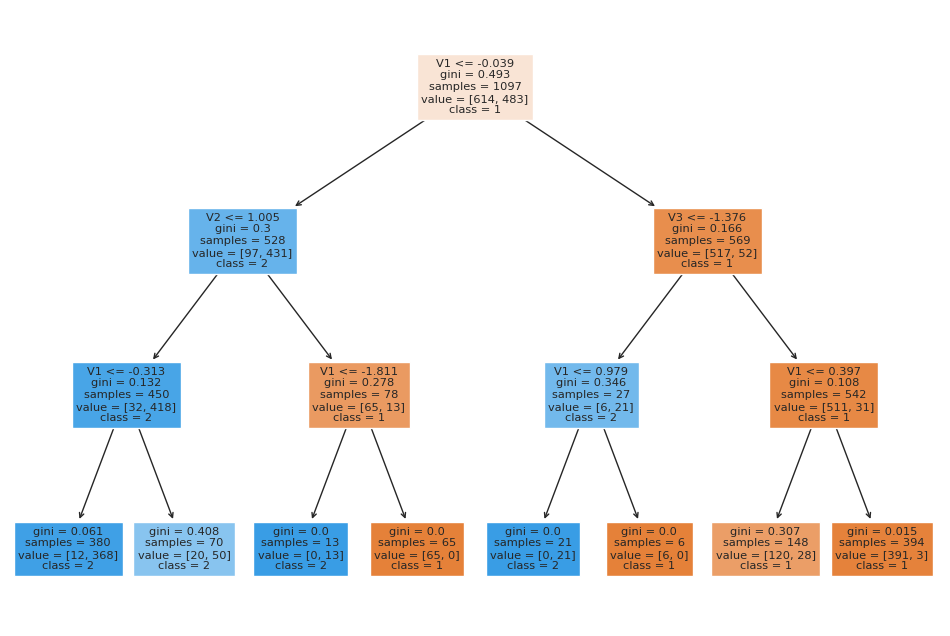

In [ ]:
# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names = X.columns.tolist(), class_names = class_names)
plt.show()

#### Random Forest

In [ ]:
# Random Forest
# Find best model through cross validation
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': max_depth,
           'min_samples_split': randint(2,20),
           'min_samples_leaf': randint(1,10),
           'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42),
                           param_distributions = rf_grid,
                           n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Train model
rf_cv.fit(X_train, y_train)
rf_model = rf_cv.best_estimator_ # best random forest model

# Prediction
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluation
rf_report = classification_report(y_test, y_pred_rf, target_names = class_names)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
log_loss_rf = log_loss(y_test, y_pred_proba_rf)

# Results
print('Random Forest Evaluation (Baseline)\n')
print(rf_report)
print(f'Accuracy: {accuracy_rf}\nLog Loss: {log_loss_rf}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Random Forest Evaluation (Baseline)

              precision    recall  f1-score   support

           1       0.97      1.00      0.99       148
           2       1.00      0.97      0.98       127

    accuracy                           0.99       275
   macro avg       0.99      0.98      0.99       275
weighted avg       0.99      0.99      0.99       275

Accuracy: 0.9854545454545455
Log Loss: 0.03990730606869672


#### AdaBoost

In [ ]:
# AdaBoost
ab_model = AdaBoostClassifier(random_state = 42)
ab_model.fit(X_train, y_train)

# Prediction
y_pred_ab = ab_model.predict(X_test)
y_pred_proba_ab = ab_model.predict_proba(X_test)

# Evaluation
ab_report = classification_report(y_test, y_pred_ab, target_names = class_names)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
log_loss_ab = log_loss(y_test, y_pred_proba_ab)

# Results
print('AdaBoost Evaluation\n')
print(ab_report)
print(f'Accuracy: {accuracy_ab}\nLog Loss: {log_loss_ab}')

AdaBoost Evaluation

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       148
           2       0.99      0.99      0.99       127

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

Accuracy: 0.9927272727272727
Log Loss: 0.44035796445289394


#### XGBoost

In [ ]:
# XGBoost
xgb_grid = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.5, 1),
    'min_child_weight': randint(1, 5),
    'subsample': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.4),
    'reg_alpha': uniform(0, 40),
    'reg_lambda': uniform(0, 1)
}

xgb_cv = RandomizedSearchCV(
    XGBClassifier(objective='multi:softprob', num_class=3),
    param_distributions = xgb_grid,
    n_iter = 100,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
    random_state = 42
)

# Train model
y_train_zero_based = y_train - 1
y_test_zero_based = y_test - 1

xgb_cv.fit(X_train, y_train_zero_based)
xgb_model = xgb_cv.best_estimator_  # best XGBoost model

# Prediction
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_labels = np.argmax(y_pred_xgb, axis=1)

# Since you adjusted the classes in y_test, you must compare against the adjusted y_test
accuracy_xgb = accuracy_score(y_test_zero_based, y_pred_xgb_labels)
from sklearn.preprocessing import LabelBinarizer

# Binarize y_test_zero_based
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_zero_based)

# Now y_test_binarized has three columns, one for each class
log_loss_xgb = log_loss(y_test_binarized, y_pred_xgb_labels)

# For the classification report, the target names should match the zero-based class labels
class_names_zero_based = ['0', '1', '2']  # Ensure this matches your actual zero-based classes
xgb_report = classification_report(y_test_zero_based, y_pred_xgb_labels, target_names=['0', '1'])
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Results
print('XGBoost Evaluation\n')
print(xgb_report)
print(f'Accuracy: {accuracy_xgb}\nLog Loss: {log_loss_xgb}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Evaluation

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       148
           1       0.95      0.95      0.95       127

    accuracy                           0.96       275
   macro avg       0.96      0.96      0.96       275
weighted avg       0.96      0.96      0.96       275

Accuracy: 0.9563636363636364
Log Loss: 1.572813966070567


#### Neural Network

Epoch 1/25
28/28 [==============================] - 2s 19ms/step - loss: 0.8043 - accuracy: 0.7241 - val_loss: 0.5766 - val_accuracy: 0.8273
Epoch 2/25
28/28 [==============================] - 0s 6ms/step - loss: 0.4292 - accuracy: 0.8746 - val_loss: 0.3165 - val_accuracy: 0.9318
Epoch 3/25
28/28 [==============================] - 0s 7ms/step - loss: 0.2239 - accuracy: 0.9384 - val_loss: 0.1563 - val_accuracy: 0.9409
Epoch 4/25
28/28 [==============================] - 0s 6ms/step - loss: 0.1172 - accuracy: 0.9681 - val_loss: 0.0846 - val_accuracy: 0.9818
Epoch 5/25
28/28 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.9772 - val_loss: 0.0518 - val_accuracy: 0.9864
Epoch 6/25
28/28 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9806 - val_loss: 0.0372 - val_accuracy: 0.9864
Epoch 7/25
28/28 [==============================] - 0s 4ms/step - loss: 0.0414 - accuracy: 0.9840 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 8/25
28/28 [=

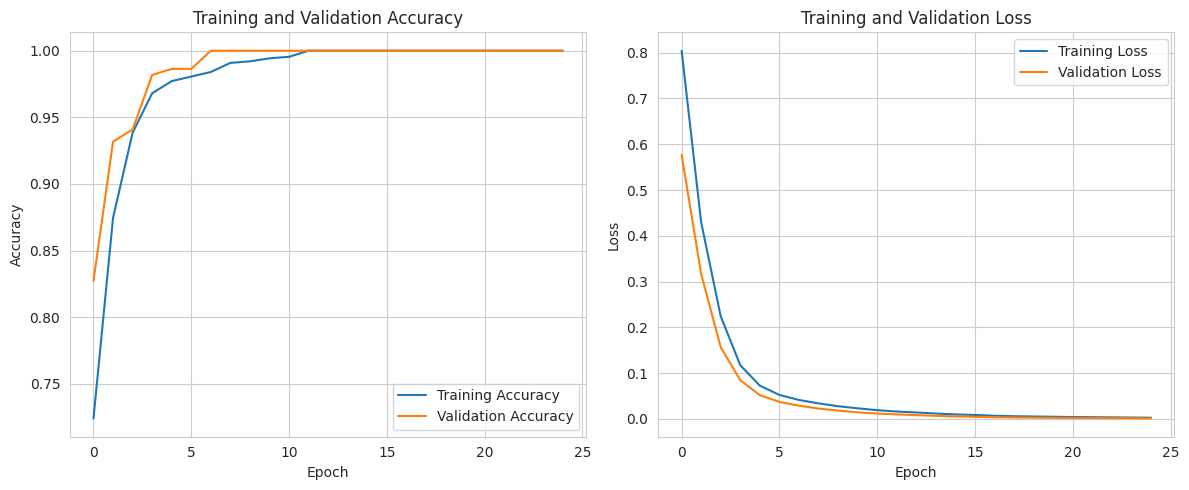

In [ ]:
# Neural Network
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Adjust num_classes if needed based on unique labels found
num_classes = max(np.max(y_train), np.max(y_test)) + 1  # +1 because indexing starts at 0

# Convert labels to categorical
y_train_categ = to_categorical(y_train, num_classes)
y_test_categ = to_categorical(y_test, num_classes)


# Build model
neural_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]), # add layers
    Dense(64, activation='relu'),
    Dense(y_train_categ.shape[1], activation='softmax')
])

# Compile model
neural_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train model
history_neural = neural_model.fit(X_train, y_train_categ, epochs = 25,
                                  batch_size = 32, verbose = 1, validation_split=0.2)

# Traning Accuracy and Loss Visualization
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history_neural.history['accuracy'], label='Training Accuracy')
plt.plot(history_neural.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_neural.history['loss'], label='Training Loss')
plt.plot(history_neural.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediction
y_pred_proba_neural = neural_model.predict(X_test)
y_pred_neural = np.argmax(y_pred_proba_neural, axis=1)
true_labels = np.argmax(y_test_categ, axis=1)

# Evaluation
neural_report = classification_report(true_labels, y_pred_neural, target_names = class_names)
log_loss_neural, accuracy_neural = neural_model.evaluate(X_test, y_test_categ)

# Results
print('Neural Network Evaluation\n')
print(neural_report)
print(f'Accuracy: {accuracy_neural}\nLog Loss: {log_loss_neural}')

9/9 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000
Neural Network Evaluation

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Accuracy: 1.0
Log Loss: 0.002384541556239128


### Model Selection

#### ROC Curve

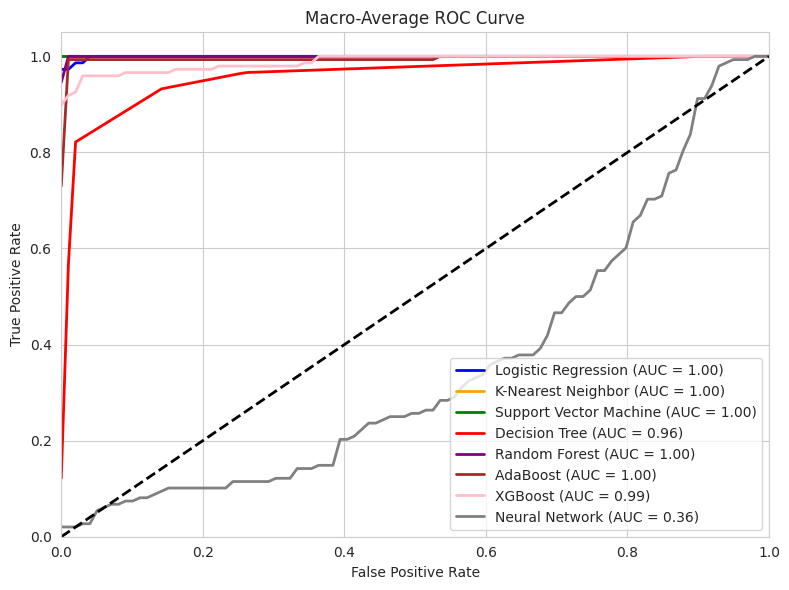

In [ ]:
# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1])

# Macro-Average ROC Curve for Comparison
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])

model_predictions = [
    (y_pred_proba_lr, 'Logistic Regression'),
    (y_pred_proba_knn, 'K-Nearest Neighbor'),
    (y_pred_proba_svm, 'Support Vector Machine'),
    (y_pred_proba_dt, 'Decision Tree'),
    (y_pred_proba_rf, 'Random Forest'),
    (y_pred_proba_ab, 'AdaBoost'),
    (y_pred_proba_xgb, 'XGBoost'),
    (y_pred_proba_neural, 'Neural Network')
]

# Calculate and plot macro-average ROC curve and ROC area for each model
for model_proba, title in model_predictions:
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    num_classes = y_test_binarized.shape[1]

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
# Model names
model = ['Logistic Regression', 'K-Nearest Neighbor', 'Support Vector Machine',
         'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'Neural Network']

# Performance metrics
performance = {
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_svm, accuracy_dt,
                 accuracy_rf, accuracy_ab, accuracy_xgb, accuracy_neural],
    'Log Loss': [log_loss_lr, log_loss_knn, log_loss_svm, log_loss_dt,
                 log_loss_rf, log_loss_ab, log_loss_xgb, log_loss_neural],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_lr[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_knn[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_svm[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_dt[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_rf[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_ab[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_xgb[:, 1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_neural[:, 1], multi_class='ovr', average='macro')
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_knn, average='macro'),
        precision_score(y_test, y_pred_svm, average='macro'),
        precision_score(y_test, y_pred_dt, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_ab, average='macro'),
        precision_score(y_test, y_pred_xgb_labels, average='macro'),
        precision_score(y_test, y_pred_neural, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_knn, average='macro'),
        recall_score(y_test, y_pred_svm, average='macro'),
        recall_score(y_test, y_pred_dt, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_ab, average='macro'),
        recall_score(y_test, y_pred_xgb_labels, average='macro'),
        recall_score(y_test, y_pred_neural, average='macro')
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_knn, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_ab, average='macro'),
        f1_score(y_test, y_pred_xgb_labels, average='macro'),
        f1_score(y_test, y_pred_neural, average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_lr, average='micro'),
        f1_score(y_test, y_pred_knn, average='micro'),
        f1_score(y_test, y_pred_svm, average='micro'),
        f1_score(y_test, y_pred_dt, average='micro'),
        f1_score(y_test, y_pred_rf, average='micro'),
        f1_score(y_test, y_pred_ab, average='micro'),
        f1_score(y_test, y_pred_xgb_labels, average='micro'),
        f1_score(y_test, y_pred_neural, average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_ab, average='weighted'),
        f1_score(y_test, y_pred_xgb_labels, average='weighted'),
        f1_score(y_test, y_pred_neural, average='weighted')
    ]
}

performance_df = pd.DataFrame(performance, index=model).sort_values(by=['Accuracy'], ascending=False)
print(performance_df)

                        Accuracy  Log Loss   ROC AUC  Precision    Recall  \
K-Nearest Neighbor      1.000000  0.001474  1.000000   1.000000  1.000000   
Support Vector Machine  1.000000  0.002462  1.000000   1.000000  1.000000   
Neural Network          1.000000  0.002385  0.000000   1.000000  1.000000   
AdaBoost                0.992727  0.440358  0.994361   0.992685  0.992685   
Random Forest           0.985455  0.039907  0.999574   0.986842  0.984252   
Logistic Regression     0.978182  0.055237  0.999362   0.977647  0.978612   
XGBoost                 0.956364  1.572814  0.988987   0.015748  0.013514   
Decision Tree           0.898182  0.261697  0.959007   0.900291  0.895350   

                        F1 Score (macro)  F1 Score (micro)  \
K-Nearest Neighbor              1.000000          1.000000   
Support Vector Machine          1.000000          1.000000   
Neural Network                  1.000000          1.000000   
AdaBoost                        0.992685          0.992727

KNN is the best model based on the performance metrics.

### Feature Evaluation

In [ ]:
# Convert X_train, X_test to dataframe for LIME and SHAP
if isinstance(X_test, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=ba.drop('class', axis=1).columns)
if isinstance(X_train, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=ba.drop('class', axis=1).columns)

#### LIME

In [ ]:
# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train_df.values,
    feature_names = X_train_df.columns.tolist(),
    class_names = label_encoder.classes_,
    mode = 'classification'
)

# LIME Explaination
indices = np.random.randint(0, X_test_df.shape[0], size=3)
for i in indices:
    explanation = explainer.explain_instance(X_test_df.values[i], knn_model.predict_proba, num_features=len(X_train_df.columns))
    explanation.show_in_notebook(show_table=True, show_all=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
n = ba.shape[0] # sample size
indices = np.random.randint(0, X_test_df.shape[0], size = n)
feature_score_lime = {feature: 0 for feature in X_train_df.columns}

for i in indices:
  explanation = explainer.explain_instance(X_test_df.values[i], knn_model.predict_proba, num_features=len(X_train_df.columns))
  exp_list = explanation.as_list()

  for tup in exp_list:
    feature, score = tup[0], tup[1]

    # Get total influential score for each feature
    for key, value in feature_score_lime.items():
      if key in feature:
        feature_score_lime[key] += abs(score)

# Get average influential value
for key, value in feature_score_lime.items():
  feature_score_lime[key] /= n

# Sort the dictionary by values
sorted_feature_lime = sorted(feature_score_lime.items(), key=lambda x: x[1])

# Create a DataFrame to display the result
df_feature_lime = pd.DataFrame(sorted_feature_lime, columns=['Feature', 'Score'])
print(df_feature_lime)

  Feature     Score
0      V4  0.035061
1      V3  0.202094
2      V2  0.205888
3      V1  0.290717


#### SHAP

In [ ]:
# Initialize LinearExplainer
explainer = shap.KernelExplainer(knn_model.predict_proba, X_train)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Randomly select 3 indices
indices = np.random.choice(X_test.shape[0], size=3, replace=False)

# (number_of_samples, number_of_features, number_of_classes)
(np.array(shap_values).shape)

  0%|          | 0/275 [00:00<?, ?it/s]

(275, 4, 2)

In [ ]:
for i in indices:
    shap.initjs()
    print(f"Index: {i}")

    for class_index in range(shap_values.shape[2]):  # Loop through each class
        explainer_value = explainer.expected_value[class_index]
        shap_values_class = shap_values[i, :, class_index]

        # Display the SHAP force plot for each class for the selected instance
        print(f"Class Index: {class_index}")
        plot = shap.force_plot(explainer_value, shap_values_class, X_test_df.iloc[i, :], link="logit", show = False)
        display(plot)

Index: 180
Class Index: 0


Class Index: 1


Index: 41
Class Index: 0


Class Index: 1


Index: 131
Class Index: 0


Class Index: 1


**General Interpretation**\
f(x): The base value, which indicates the average model output (probability) over the training set for certain class.\
Red arrows: Indicate feature values that push the prediction higher than the base value for a given class.\
Blue arrows: Indicate feature values that pull the prediction lower than the base value for that class.\
Length of arrows: Represents the magnitude of the feature's contribution to the prediction.\
Position of the feature label: Indicates the actual value of that feature for the instance being explained.\
The output value for the prediction is the final position on the x-axis after all the feature contributions have been taken into account. If it is greater than the base value, the model predicts that this instance is more likely to be in that class; if it is less, it predicts it is less likely to be in the class.

In [ ]:
n = ba.shape[0] # sample size
indices = np.random.choice(X_test_df.shape[0], size=n)
shap_values_subset = shap_values[indices]

In [ ]:
# Convert the list of SHAP values for each class into array
shap_values_array = np.stack(shap_values_subset, axis=1)

# Compute the mean of the absolute SHAP values across the selected instances for each feature
mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

# Create a dictionary for feature scores
feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}
sorted_feature_shap = sorted(feature_score_shap.items(), key=lambda x: x[1])

# Display
df_feature_shap = pd.DataFrame(sorted_feature_shap, columns=['Feature', 'Score'])
print(df_feature_shap)

  Feature     Score
0      V3  0.110529
1      V2  0.133071
2      V4  0.164021
3      V1  0.167173


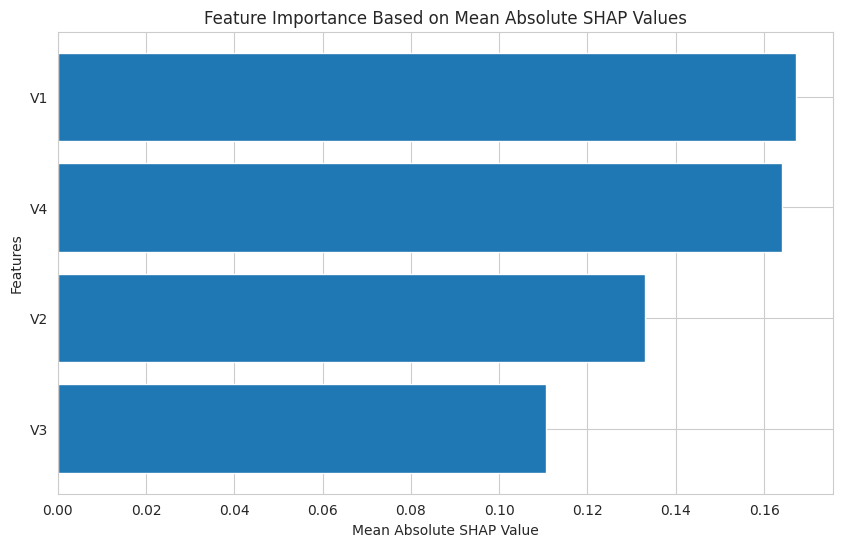

In [ ]:
if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

# Sort the feature importances by their mean absolute SHAP values
feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}
sorted_feature_importances = sorted(feature_score_shap.items(), key=lambda x: x[1], reverse=True)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), [score for feature, score in sorted_feature_importances], tick_label=[feature for feature, score in sorted_feature_importances])
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Mean Absolute SHAP Values')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

### Model Optimization

#### After LIME

In [ ]:
# Drop non-influential features
drop_features_lime = ['V4']
X_train_lime = X_train_df.drop(columns = drop_features_lime)
X_test_lime = X_test_df.drop(columns = drop_features_lime)

# Logistic Regression
lime_model = KNeighborsClassifier()
lime_model.fit(X_train_lime, y_train)

# Evaluation
y_pred_lime = lime_model.predict(X_test_lime)
y_pred_proba_lime = lime_model.predict_proba(X_test_lime)
lime_report = classification_report(y_test, y_pred_lime, target_names = class_names)
accuracy_lime = accuracy_score(y_test, y_pred_lime)
log_loss_lime = log_loss(y_test, y_pred_proba_lime)

# Results
print('KNN Evaluation (LIME-Informed Model)\n')
print(lime_report)
print(f'Accuracy: {accuracy_lime}\nLog Loss: {log_loss_lime}')

KNN Evaluation (LIME-Informed Model)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Accuracy: 1.0
Log Loss: 0.0026689788184736767


#### After SHAP

In [ ]:
# Drop the identified non-influential features from the training and test sets
drop_features_shap = ['V3']
X_train_shap = X_train_df.drop(columns=drop_features_shap)
X_test_shap = X_test_df.drop(columns=drop_features_shap)

# Fit the model on the reduced feature set
shap_model = KNeighborsClassifier()
shap_model.fit(X_train_shap, y_train)

# Make predictions with the updated model on the reduced feature test set
y_pred_shap = shap_model.predict(X_test_shap)
y_pred_proba_shap = shap_model.predict_proba(X_test_shap)

# Generate a classification report
shap_report = classification_report(y_test, y_pred_shap, target_names=class_names)

# Calculate accuracy and log loss
accuracy_shap = accuracy_score(y_test, y_pred_shap)
log_loss_shap = log_loss(y_test, y_pred_proba_shap)

# Print results
print('KNN Evaluation (SHAP-Informed Model)\n')
print(shap_report)
print(f'Accuracy: {accuracy_shap}\nLog Loss: {log_loss_shap}')

KNN Evaluation (SHAP-Informed Model)

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       148
           2       0.96      0.97      0.96       127

    accuracy                           0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275

Accuracy: 0.9672727272727273
Log Loss: 0.4420224835429112


### Comparison

#### ROC Curve

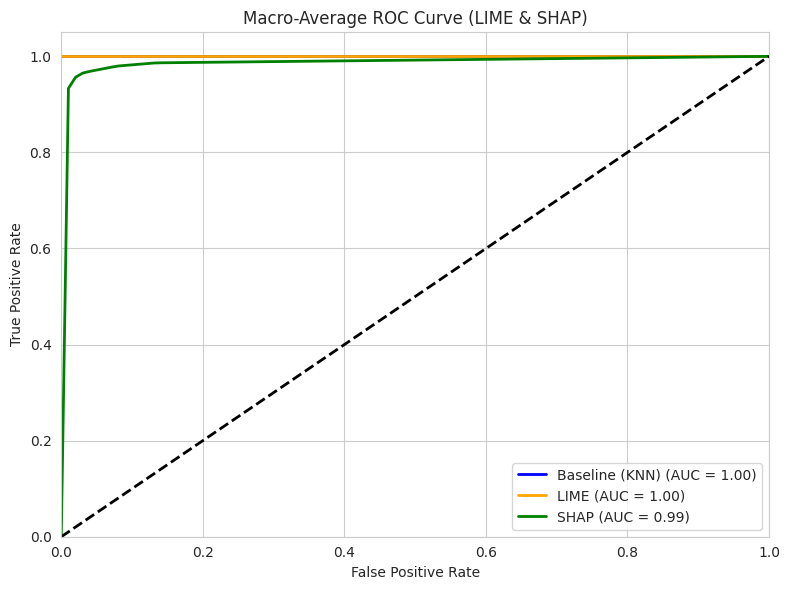

In [ ]:
# Macro-Average ROC Curve for Comparison
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green'])

# Calculate and plot macro-average ROC curve and ROC area for each model
eml_predictions = [
    (y_pred_proba_knn, 'Baseline (KNN)'),
    (y_pred_proba_lime, 'LIME'),
    (y_pred_proba_shap, 'SHAP')
]

for model_proba, title in eml_predictions:
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    num_classes = y_test_binarized.shape[1]

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve (LIME & SHAP)')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
# Index
eml_index = ['Baseline (KNN)', 'LIME', 'SHAP']

# Performance metrics
performance_eml = {
    'Accuracy': [accuracy_knn, accuracy_lime, accuracy_shap],
    'Log Loss': [log_loss_knn, log_loss_lime, log_loss_shap],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_knn[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_lime[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_shap[:,1], multi_class='ovr', average='macro')
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn, average='macro'),
        precision_score(y_test, y_pred_lime, average='macro'),
        precision_score(y_test, y_pred_shap, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn, average='macro'),
        recall_score(y_test, y_pred_lime, average='macro'),
        recall_score(y_test, y_pred_shap, average='macro')
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_knn, average='macro'),
        f1_score(y_test, y_pred_lime, average='macro'),
        f1_score(y_test, y_pred_shap, average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_knn, average='micro'),
        f1_score(y_test, y_pred_lime, average='micro'),
        f1_score(y_test, y_pred_shap, average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_lime, average='weighted'),
        f1_score(y_test, y_pred_shap, average='weighted')
    ]
}

eml_compare = pd.DataFrame(performance_eml, index=eml_index).sort_values(by=['Accuracy'], ascending=False)
print(eml_compare)

                Accuracy  Log Loss   ROC AUC  Precision   Recall  \
Baseline (KNN)  1.000000  0.001474  1.000000   1.000000  1.00000   
LIME            1.000000  0.002669  1.000000   1.000000  1.00000   
SHAP            0.967273  0.442022  0.986593   0.966863  0.96736   

                F1 Score (macro)  F1 Score (micro)  F1 Score (weighted)  
Baseline (KNN)          1.000000          1.000000             1.000000  
LIME                    1.000000          1.000000             1.000000  
SHAP                    0.967099          0.967273             0.967281  


### Summary Plot

ExactExplainer explainer: 276it [00:26,  7.10it/s]                         


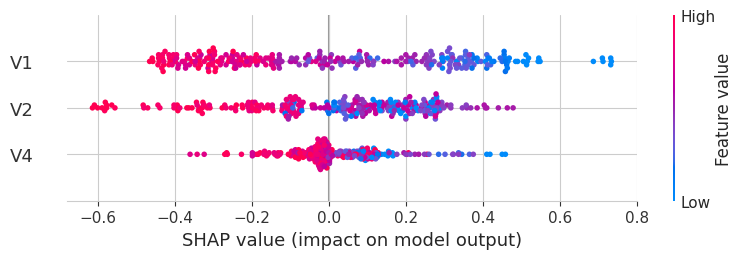

In [ ]:
import shap
from sklearn.neighbors import KNeighborsClassifier

class SHAPModelEvaluator:
    def __init__(self, model, X_train_df, X_test_df, y_train, drop_features):
        self.model = model
        self.X_train_df = X_train_df
        self.X_test_df = X_test_df
        self.y_train = y_train
        self.drop_features = drop_features

    def generate_summary_plot(self):
        # Reduce the feature set based on SHAP feature importance
        X_train_shap = self.X_train_df.drop(columns=self.drop_features)
        X_test_shap = self.X_test_df.drop(columns=self.drop_features)

        # Fit the model on the reduced feature set
        self.model.fit(X_train_shap, self.y_train)

        # Create a SHAP explainer
        explainer = shap.Explainer(self.model.predict, X_train_shap)

        # Calculate SHAP values for the test set
        shap_values = explainer(X_test_shap)

        # Generate summary plot
        shap.summary_plot(shap_values, X_test_shap)

# Initialize model
shap_model = KNeighborsClassifier()

evaluator = SHAPModelEvaluator(shap_model, X_train_df, X_test_df, y_train, drop_features_shap)

# Generate and display the summary plot
evaluator.generate_summary_plot()
